Este é um pequeno estudo pessoal, que analisa um dataset de saúde e estilo de vida, fornecido no Kaggle.

Aqui são feitas algumas observações com gráficos, também utilizando um modelo de machine learning.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import accuracy_score

In [ ]:
#Carregar o dataset
df = pd.read_csv("data\\health_lifestyle_dataset.csv")

df = df.rename(columns={
    "age": "idade",
    "gender": "genero",
    "bmi": "imc",
    "daily_steps": "passos_diarios",
    "sleep_hours": "horas_sono",
    "water_intake_l": "agua_litros",
    "calories_consumed": "calorias_consumidas",
    "smoker": "fumante",
    "alcohol": "alcool",
    "resting_hr": "fc_repouso",
    "systolic_bp": "pressao_sistolica",
    "diastolic_bp": "pressao_diastolica",
    "cholesterol": "colesterol",
    "family_history": "historico_familiar",
    "disease_risk": "risco_doenca"
})

#Remover linhas com valores nulos
df = df.dropna().reset_index(drop=True)

#Converter variáveis categóricas
df["genero"] = df["genero"].map({1: "Masculino", 0: "Feminino"})

#Separar variáveis independentes e dependente
X = df.drop(["id", "risco_doenca"], axis=1).astype(float)
y = df["risco_doenca"]

#Dividir os dados em treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.3, random_state=12)

#Treinar o modelo
modelo = RandomForestClassifier(random_state=12)
modelo.fit(X_treino, y_treino)

#Avaliar o modelo
y_pred = modelo.predict(X_teste)
precisao = accuracy_score(y_teste, y_pred)
print(f"Precisão do modelo: {precisao:.2%}\n")

Precisão do modelo: 75.07%



Podemos ver que enquanto algumas variáveis são mais imporatnte que outras, o que realmente faz a diferença é o conjunto de hábitos saudáveis, não somente alguns poucous.

Importância das variáveis:

passos_diarios         0.112090
calorias_consumidas    0.112016
imc                    0.103720
colesterol             0.099745
pressao_sistolica      0.092472
horas_sono             0.091425
idade                  0.089706
pressao_diastolica     0.088514
agua_litros            0.085166
fc_repouso             0.084302
historico_familiar     0.014245
alcool                 0.013814
fumante                0.012783
genero                 0.000000
dtype: float64


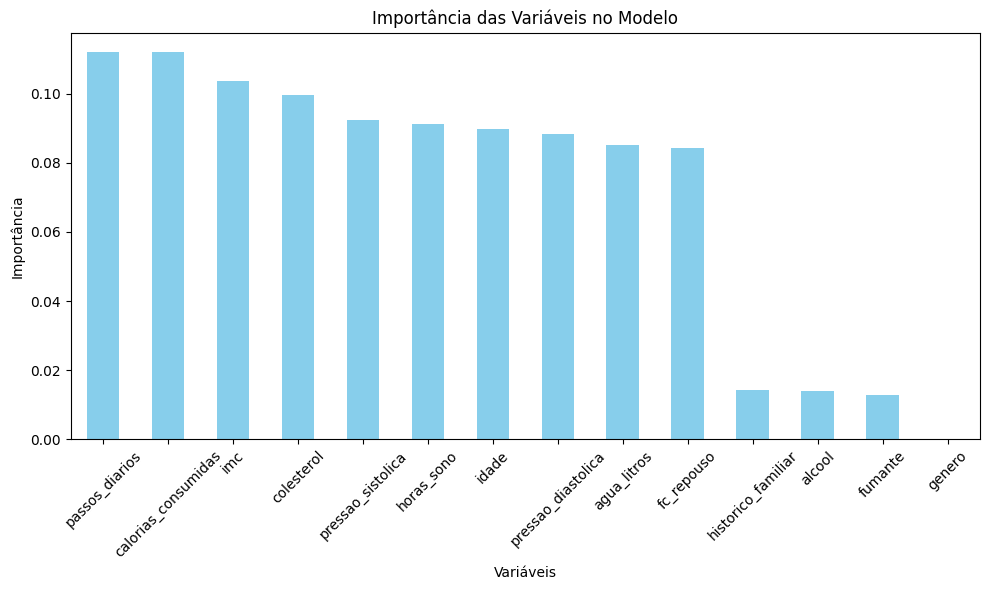

In [27]:
#Importância das variáveis
importancia_variaveis = pd.Series(modelo.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Importância das variáveis:\n")
print(importancia_variaveis)

#Gráfico da importância das variáveis
fig, ax = plt.subplots(figsize=(10,6))
importancia_variaveis.plot(kind='bar', color='skyblue', ax=ax)
ax.set_title("Importância das Variáveis no Modelo")
ax.set_ylabel("Importância")
ax.set_xlabel("Variáveis")
ax.set_xticklabels(importancia_variaveis.index, rotation=45)
plt.tight_layout()
plt.show()

Aqui vemos a correlação entre as variáveis, de acordo com risco de doença.
Não conseguimos observar 2 variáveis que indiquem uma correlação forte para determinar o risco de doença.

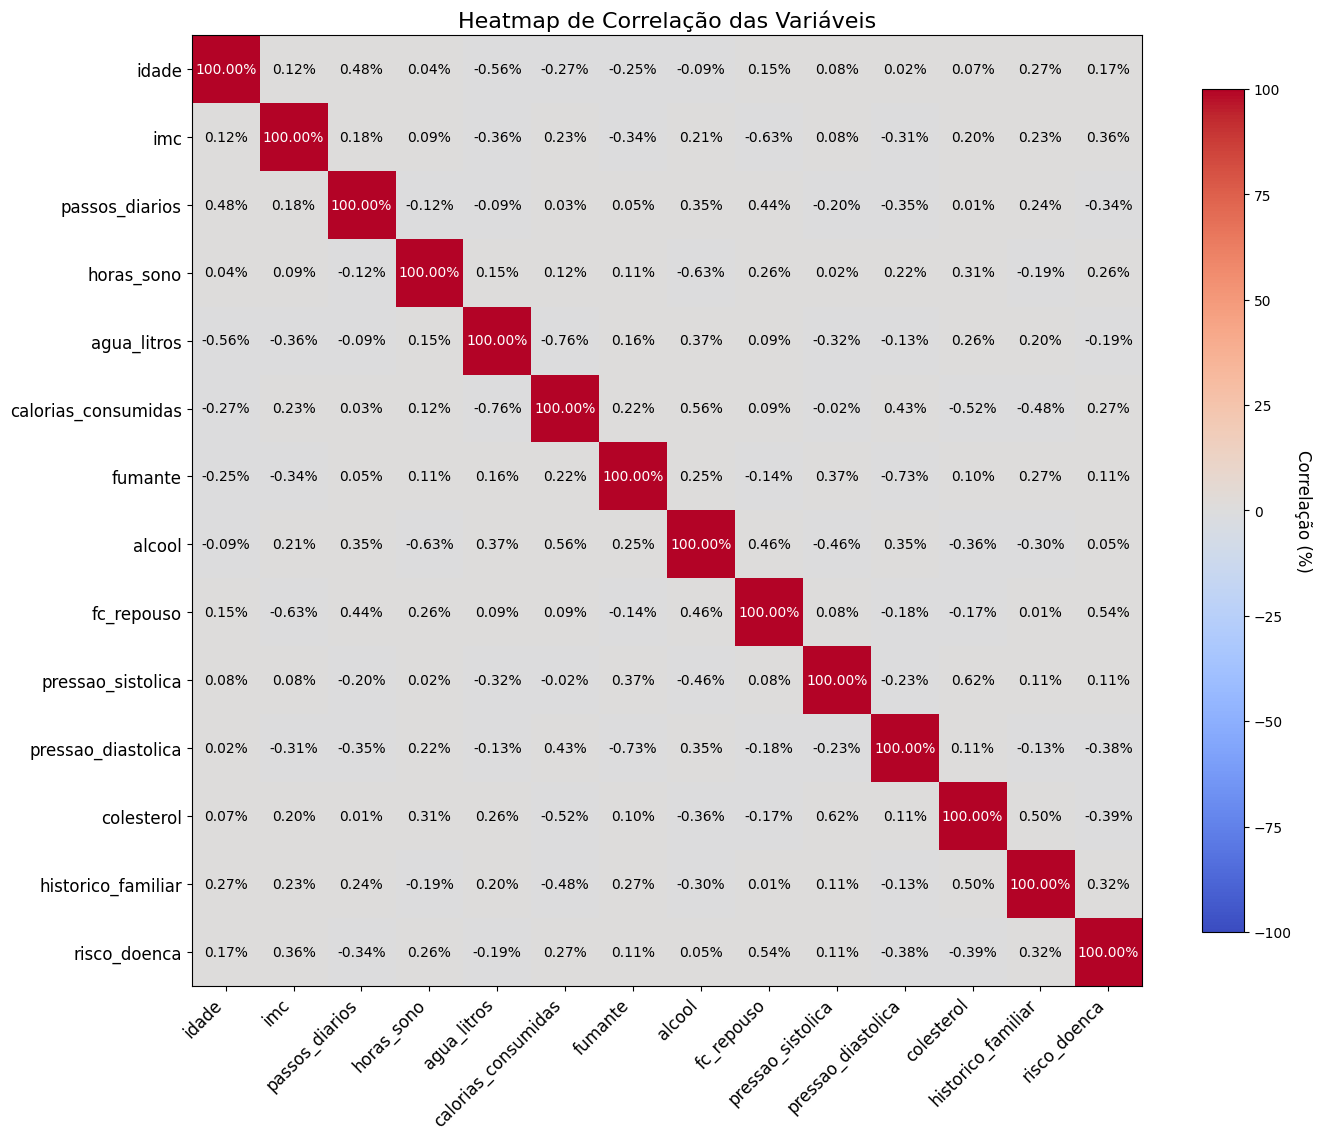

In [28]:
# Calcular a correlação das colunas numéricas
corr = df.drop(columns=["id","genero"]).astype(float).corr()
corr_percent = corr * 100

fig, ax = plt.subplots(figsize=(14,12))
im = ax.imshow(corr_percent, cmap='coolwarm', vmin=-100, vmax=100, interpolation='nearest')

ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha='right', fontsize=12)
ax.set_yticklabels(corr.columns, fontsize=12)

for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        valor = corr_percent.iloc[i, j]
        cor = "black" if abs(valor) < 50 else "white"
        ax.text(j, i, f"{valor:.2f}%", ha="center", va="center", color=cor, fontsize=10)

cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label("Correlação (%)", rotation=270, labelpad=15, fontsize=12)

plt.title("Heatmap de Correlação das Variáveis", fontsize=16)
plt.tight_layout()
plt.show()

Neste gráfico, vemos a correlação do valor da variável (quanto maior) e como o valor afeta a decisão do risco de doença

Esse gráfico é bom para analisar correlações para analisar estudos e tirar novas conclusões

Vermelhos: Quanto mais, mais risco
Azuis: Quanto mais, menos risco

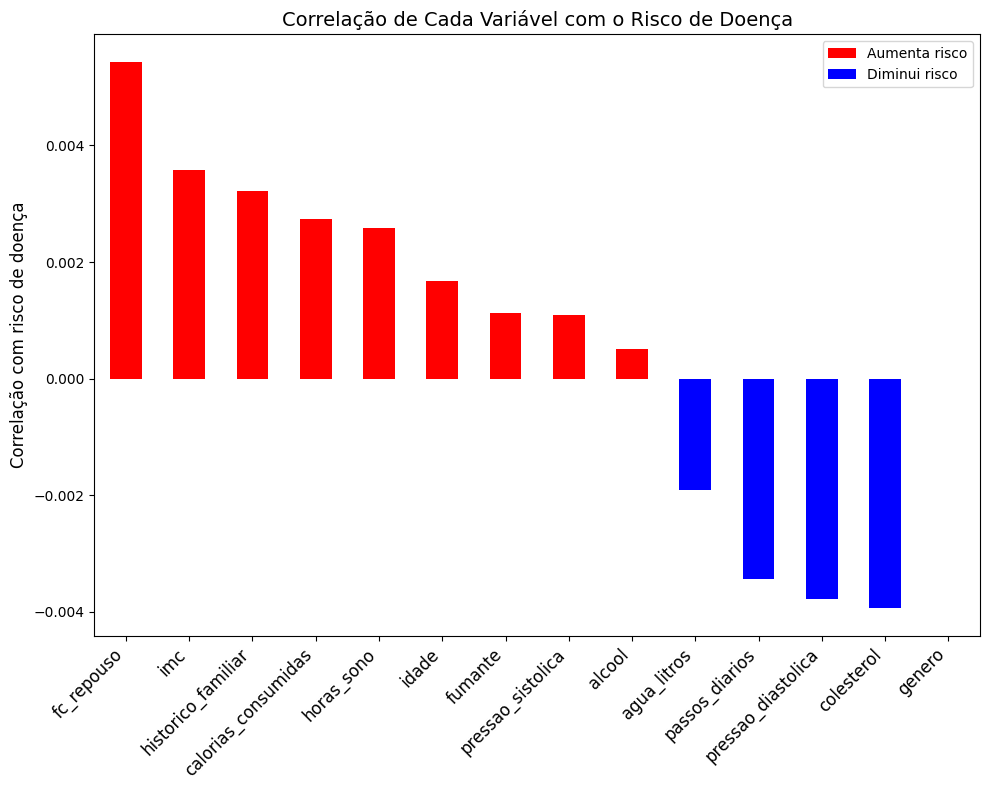

In [29]:
#Correlação das variáveis com o risco de doença
X = df.drop(columns=["id", "risco_doenca"]).astype(float)
y = df["risco_doenca"]

corr_com_risco = X.corrwith(y).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10,8))
cores = corr_com_risco.apply(lambda x: 'red' if x > 0 else 'blue')  # vermelho = aumenta risco, azul = diminui risco

corr_com_risco.plot(kind='bar', color=cores, ax=ax)
ax.set_ylabel("Correlação com risco de doença", fontsize=12)
ax.set_title("Correlação de Cada Variável com o Risco de Doença", fontsize=14)
ax.set_xticklabels(corr_com_risco.index, rotation=45, ha='right', fontsize=12)

from matplotlib.patches import Patch
elementos_legenda = [
    Patch(facecolor='red', label='Aumenta risco'),
    Patch(facecolor='blue', label='Diminui risco')
]
ax.legend(handles=elementos_legenda)

plt.tight_layout()
plt.show()

In [30]:
import matplotlib.pyplot as plt


# Função para avaliar saúde física
def classificar_saude(linha):
    pontuacao = 0
    
    # passos_diarios: maior que a média = saudável
    if linha['passos_diarios'] >= 10000:
        pontuacao += 1
        
    # imc: dentro da faixa 18.5–25 = saudável
    if 18.5 <= linha['imc'] <= 25:
        pontuacao += 1
        
    # horas_sono: maior que a média = saudável
    if 7 <= linha['horas_sono'] <= 9:
        pontuacao += 1
        
    # agua_litros: maior que a média = saudável
    if linha['agua_litros'] >= 2:
        pontuacao += 1
        
    # colesterol: menor que a média = saudável
    if linha['colesterol'] <= 190:
        pontuacao += 1
        
    # Definir limiar: pelo menos metade das variáveis dentro da faixa saudável
    return 'Fisicamente Saudável' if pontuacao >= 3 else 'Não Saudável'

# Aplicar função ao DataFrame
df['saude_fisica'] = df.apply(classificar_saude, axis=1)

# Visualizar
df[['id','passos_diarios','imc','horas_sono','agua_litros','colesterol','saude_fisica']]


,id,passos_diarios,imc,horas_sono,agua_litros,colesterol,saude_fisica
0,1,4198,20.5,3.9,3.4,240,Não Saudável
1,2,14359,33.3,9.0,4.7,207,Fisicamente Saudável
2,3,1817,31.6,6.6,4.2,296,Não Saudável
3,4,15772,38.2,3.6,2.0,175,Fisicamente Saudável
4,5,6037,33.6,3.8,4.0,294,Não Saudável
...,...,...,...,...,...,...,...
99995,99996,4726,33.1,3.9,2.0,282,Não Saudável
99996,99997,11554,35.1,4.5,3.1,192,Não Saudável
99997,99998,3924,18.9,3.8,1.0,218,Não Saudável
99998,99999,16110,27.8,5.6,0.8,188,Não Saudável


Este gráfico analisa o grupo de pessoas classificadas como “Não Saudáveis” e verifica quais variáveis relacionadas à saúde física estão fora da faixa considerada ideal.

Podemos observar a % de pessoas “Não Saudáveis” definido por filtros considerados ideais anteriormente, e quantas pessoas não estão num nível ideal destas variáveis.

Uma conclusão é que grande parte da população, tem seu descanso (de exercício) num bom nível, mas horas de sono, índice de massa corporal, e colesterol, são os mais irregulares (não necessariamente altos) dentro as pessoas com risco de doença

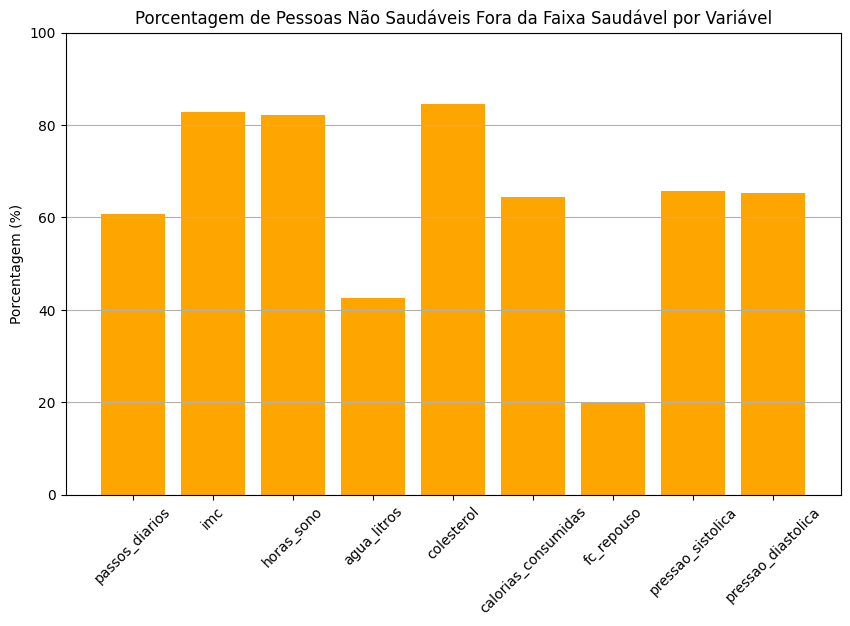

In [31]:

# Filtrar apenas pessoas não saudáveis
nao_saudavel_df = df[df['saude_fisica'] == 'Não Saudável']
total = len(nao_saudavel_df)

# Limites considerados saudáveis para cada variável
limites_saudaveis = {
    'passos_diarios': lambda x: x >= 10000,
    'imc': lambda x: (x >= 18.5) & (x <= 24.9),
    'horas_sono': lambda x: (x >= 7) & (x <= 9),
    'agua_litros': lambda x: x >= 2,
    'colesterol': lambda x: x < 190,
    'calorias_consumidas': lambda x: (x >= 1500) & (x <= 2500),
    'fc_repouso': lambda x: (x >= 60) & (x <= 100),
    'pressao_sistolica': lambda x: (x >= 90) & (x <= 120),
    'pressao_diastolica': lambda x: (x >= 60) & (x <= 80)
}

# Calcular porcentagem de pessoas fora da faixa saudável para cada coluna
fatores = {}
for coluna, condicao in limites_saudaveis.items():
    fora_da_faixa = (~condicao(nao_saudavel_df[coluna])).sum()
    fatores[coluna] = fora_da_faixa / total * 100

# Plotar gráfico
plt.figure(figsize=(10,6))
plt.bar(fatores.keys(), fatores.values(), color='orange')
plt.title('Porcentagem de Pessoas Não Saudáveis Fora da Faixa Saudável por Variável')
plt.ylabel('Porcentagem (%)')
plt.ylim(0,100)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()